In [1]:
## import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
## reading data into pandas dataframe object
data = pd.read_csv('Dataset_Uber Traffic.csv')

In [3]:
## Checking the first five rows of data
data.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [4]:
## Checking the number of records and number of features
data.shape

(48120, 4)

In [5]:
## Removing any missing values if any
data_cleaned = data.dropna()

In [6]:
## Removing any duplicate values if any
data_cleaned = data_cleaned.drop_duplicates()

In [7]:
data_cleaned.shape

(48120, 4)

In [8]:
## Ensuring correct datatypes
data_cleaned['Junction'] = data_cleaned['Junction'].astype(int)
data_cleaned['Vehicles'] = data_cleaned['Vehicles'].astype(int)
data_cleaned['DateTime'] = pd.to_datetime(data_cleaned['DateTime'])

In [9]:
## Group by DateTime (hourly) and Junction to get total vehicles per hour per junction
data_aggregated = data_cleaned.groupby(['DateTime', 'Junction']).agg({'Vehicles': 'sum'}).reset_index()

In [10]:
## Creating time-based features
data_aggregated['Hour'] = data_aggregated['DateTime'].dt.hour
data_aggregated['Day'] = data_aggregated['DateTime'].dt.day
data_aggregated['Weekday'] = data_aggregated['DateTime'].dt.weekday
data_aggregated['Month'] = data_aggregated['DateTime'].dt.month
data_aggregated['Year'] = data_aggregated['DateTime'].dt.year

In [11]:
## Creating binary indicator for weekends
data_aggregated['IsWeekend'] = data_aggregated['Weekday'].isin([5, 6]).astype(int)

In [12]:
## Creating Lag features for 1 hour and 24 hours before
data_aggregated.sort_values(['Junction', 'DateTime'], inplace=True)
data_aggregated['Lag_1hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(1)
data_aggregated['Lag_24hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(24)

In [13]:
# Dropping any rows with NaN values created due to lag features
data_aggregated.dropna(inplace=True)

In [14]:
## Defining features and target
feature_cols = ['Hour', 'Day', 'Weekday', 'Month', 'Year', 'Junction', 'IsWeekend', 'Lag_1hr', 'Lag_24hr']
X = data_aggregated[feature_cols]
y = data_aggregated['Vehicles']

In [15]:
## Normalizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

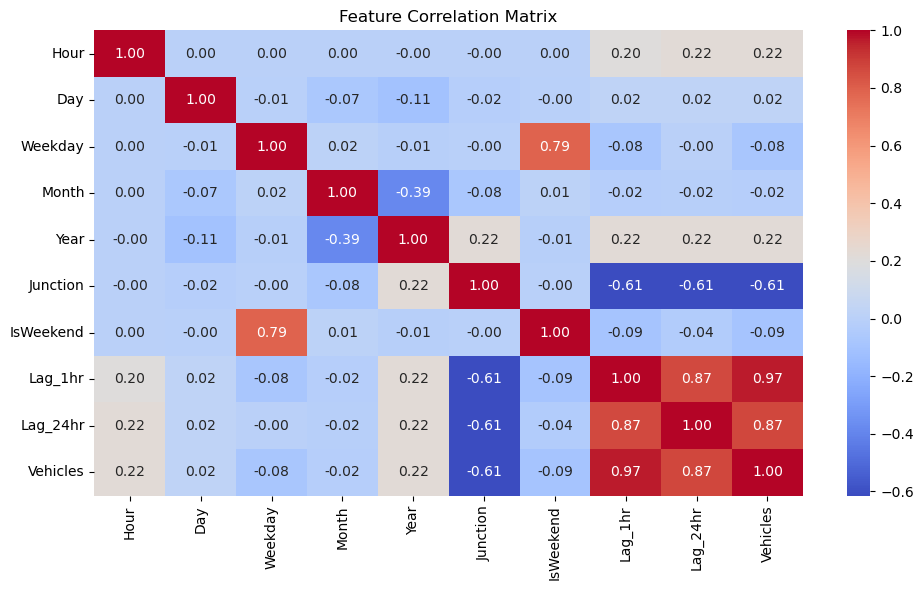

In [16]:
## Computing Correlation matrix
correlation_matrix = data_aggregated[feature_cols + ['Vehicles']].corr()

## Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [17]:
## Fitting Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [18]:
## Extracting Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

     Feature  Importance
7    Lag_1hr    0.941197
0       Hour    0.020610
8   Lag_24hr    0.013563
1        Day    0.008627
3      Month    0.005874
2    Weekday    0.004151
5   Junction    0.003497
4       Year    0.001833
6  IsWeekend    0.000646


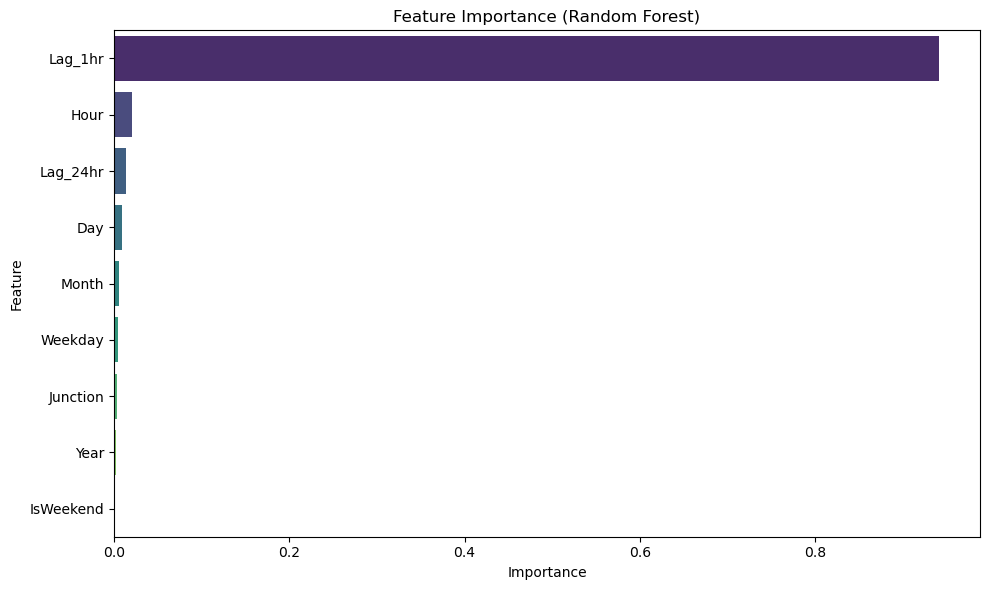

In [19]:
## Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

In [20]:
data_aggregated.head()

,DateTime,Junction,Vehicles,Hour,Day,Weekday,Month,Year,IsWeekend,Lag_1hr,Lag_24hr
72,2015-01-12 00:00:00,1,21,0,12,0,1,2015,0,15.0,15.0
75,2015-01-12 01:00:00,1,20,1,12,0,1,2015,0,21.0,13.0
78,2015-01-12 02:00:00,1,18,2,12,0,1,2015,0,20.0,10.0
81,2015-01-12 03:00:00,1,13,3,12,0,1,2015,0,18.0,7.0
84,2015-01-12 04:00:00,1,14,4,12,0,1,2015,0,13.0,9.0


In [21]:
data_aggregated.shape

(48024, 11)

In [22]:
data_aggregated.to_csv('Traffic_data.csv', index = False)

In [39]:
df = pd.read_csv('Integrated_Dataset.csv')

In [23]:
new_df = pd.read_csv('Integrated_Dataset_Gade_Pavan_Kumar_Reddy.csv')

In [24]:
new_df.head()

,DateTime,Junction,Vehicles,Hour,Day,Weekday,Month,Year,IsWeekend,Lag_1hr,Lag_24hr,Temperature_C,Precipitation_mm,WindSpeed_kmh,Humidity_percent,is_public_holiday,is_sports_event,is_concert,is_public_demonstration
0,2015-11-11 00:00:00,-1.217528,28,-1.661325,-0.627605,-0.495629,1.448992,-2.195716,-0.628768,-0.040999,-0.136390,-0.586602,-0.136252,-0.469148,0.451604,4.971346,-0.160128,-0.132378,-0.057831
1,2015-11-11 01:00:00,-1.217528,25,-1.516862,-0.627605,-0.495629,1.448992,-2.195716,-0.628768,0.252335,-0.430276,-0.660022,-0.136252,-0.493512,0.407193,4.971346,-0.160128,-0.132378,-0.057831
2,2015-11-11 02:00:00,-1.217528,19,-1.372399,-0.627605,-0.495629,1.448992,-2.195716,-0.628768,0.105668,-0.430276,-0.733442,-0.136252,-0.469148,0.407193,4.971346,-0.160128,-0.132378,-0.057831
3,2015-11-11 03:00:00,-1.217528,21,-1.227936,-0.627605,-0.495629,1.448992,-2.195716,-0.628768,-0.187666,-0.283333,-0.794625,-0.136252,-0.444783,0.407193,4.971346,-0.160128,-0.132378,-0.057831
4,2015-11-11 04:00:00,-1.217528,20,-1.083473,-0.627605,-0.495629,1.448992,-2.195716,-0.628768,-0.089888,-0.577219,-0.843572,-0.136252,-0.274233,0.451604,4.971346,-0.160128,-0.132378,-0.057831


In [25]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DateTime                 43200 non-null  object 
 1   Junction                 43200 non-null  float64
 2   Vehicles                 43200 non-null  int64  
 3   Hour                     43200 non-null  float64
 4   Day                      43200 non-null  float64
 5   Weekday                  43200 non-null  float64
 6   Month                    43200 non-null  float64
 7   Year                     43200 non-null  float64
 8   IsWeekend                43200 non-null  float64
 9   Lag_1hr                  43200 non-null  float64
 10  Lag_24hr                 43200 non-null  float64
 11  Temperature_C            43200 non-null  float64
 12  Precipitation_mm         43200 non-null  float64
 13  WindSpeed_kmh            43200 non-null  float64
 14  Humidity_percent      

In [41]:
hourly_congestion = df.groupby(['Junction', 'Hour']).agg({
    'Vehicles': 'mean'
}).rename(columns={'Vehicles': 'Avg_Vehicles'}).reset_index()

In [42]:
# Rolling average to smooth out noise
hourly_congestion['Smoothed_Vehicles'] = hourly_congestion.groupby('Junction')['Avg_Vehicles'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Identify peak hour per junction
peak_hours = hourly_congestion.loc[hourly_congestion.groupby('Junction')['Smoothed_Vehicles'].idxmax()]

In [44]:
# Day-wise pattern
weekday_pattern = df.groupby(['Weekday', 'Hour'])['Vehicles'].mean().unstack()

# Weekend comparison
weekend_pattern = df.groupby(['IsWeekend', 'Hour'])['Vehicles'].mean().unstack()

In [45]:
monthly_pattern = df.groupby(['Month', 'Hour'])['Vehicles'].mean().unstack()

In [46]:
# Correlation
correlation = df[['Vehicles', 'Temperature_C', 'Precipitation_mm', 'WindSpeed_kmh', 'Humidity_percent',
                  'is_public_holiday', 'is_sports_event', 'is_concert', 'is_public_demonstration']].corr()

# Regression to predict vehicles based on influencing factors
import statsmodels.api as sm

X = df[['Temperature_C', 'Precipitation_mm', 'WindSpeed_kmh', 'Humidity_percent',
        'is_public_holiday', 'is_sports_event', 'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)
y = df['Vehicles']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     184.0
Date:                Fri, 30 May 2025   Prob (F-statistic):          3.08e-307
Time:                        11:04:57   Log-Likelihood:            -1.9096e+05
No. Observations:               43200   AIC:                         3.819e+05
Df Residuals:                   43191   BIC:                         3.820e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [47]:
X = df[['Hour', 'IsWeekend', 'Lag_1hr', 'Lag_24hr', 'Temperature_C', 'Precipitation_mm',
        'WindSpeed_kmh', 'Humidity_percent', 'is_public_holiday', 'is_sports_event',
        'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)
y = df['Vehicles']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Vehicles   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 5.874e+04
Date:                Fri, 30 May 2025   Prob (F-statistic):               0.00
Time:                        11:05:14   Log-Likelihood:            -1.3009e+05
No. Observations:               43200   AIC:                         2.602e+05
Df Residuals:                   43187   BIC:                         2.603e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

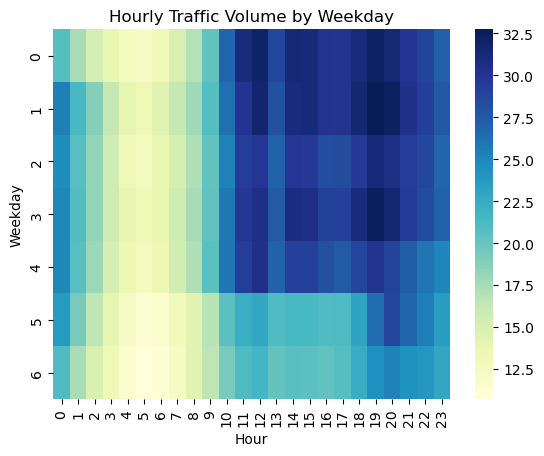

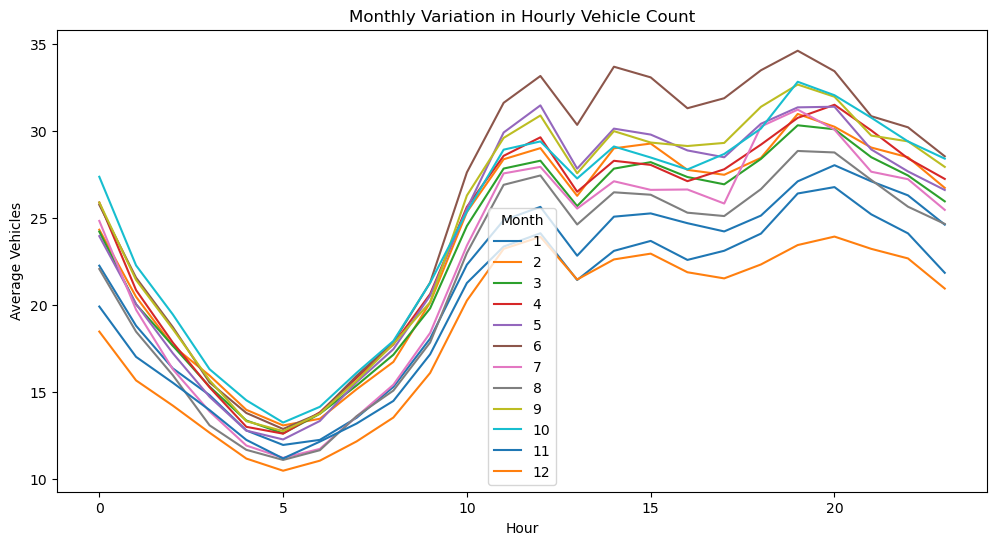

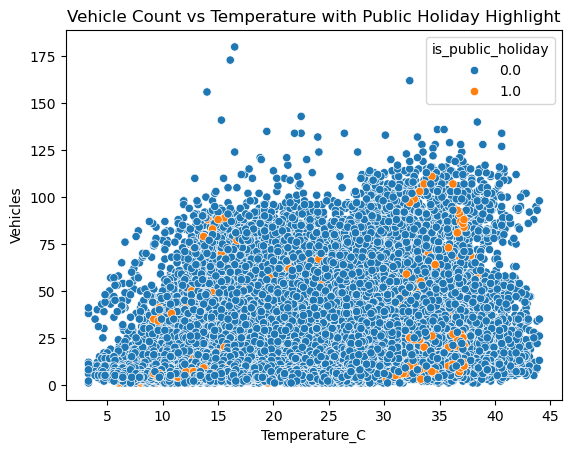

In [48]:
# Heatmap: Weekly pattern
sns.heatmap(weekday_pattern, cmap='YlGnBu')
plt.title("Hourly Traffic Volume by Weekday")
plt.show()

# Lineplot: Monthly
monthly_pattern.T.plot(figsize=(12,6))
plt.title("Monthly Variation in Hourly Vehicle Count")
plt.xlabel("Hour")
plt.ylabel("Average Vehicles")
plt.legend(title='Month')
plt.show()

# Scatter: Weather effects
sns.scatterplot(data=df, x='Temperature_C', y='Vehicles', hue='is_public_holiday')
plt.title("Vehicle Count vs Temperature with Public Holiday Highlight")
plt.show()

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['Hour', 'IsWeekend', 'Lag_1hr', 'Lag_24hr', 'Temperature_C', 'Precipitation_mm',
        'WindSpeed_kmh', 'Humidity_percent', 'is_public_holiday', 'is_sports_event',
        'is_concert', 'is_public_demonstration']]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                    feature        VIF
0                     const  53.698231
1                      Hour   1.151695
2                 IsWeekend   1.042273
3                   Lag_1hr   4.052441
4                  Lag_24hr   4.059713
5             Temperature_C   1.610897
6          Precipitation_mm   1.059744
7             WindSpeed_kmh   1.078046
8          Humidity_percent   1.777686
9         is_public_holiday   1.015285
10          is_sports_event   1.052361
11               is_concert   1.015624
12  is_public_demonstration   1.011777


In [50]:
hourly_congestion

,Junction,Hour,Avg_Vehicles,Smoothed_Vehicles
0,1,0,45.458333,45.458333
1,1,1,38.815217,42.136775
2,1,2,33.652174,39.308575
3,1,3,29.177536,33.881643
4,1,4,25.364130,29.397947
...,...,...,...,...
91,4,19,8.909722,8.949074
92,4,20,9.229167,8.958333
93,4,21,8.597222,8.912037
94,4,22,8.958333,8.928241


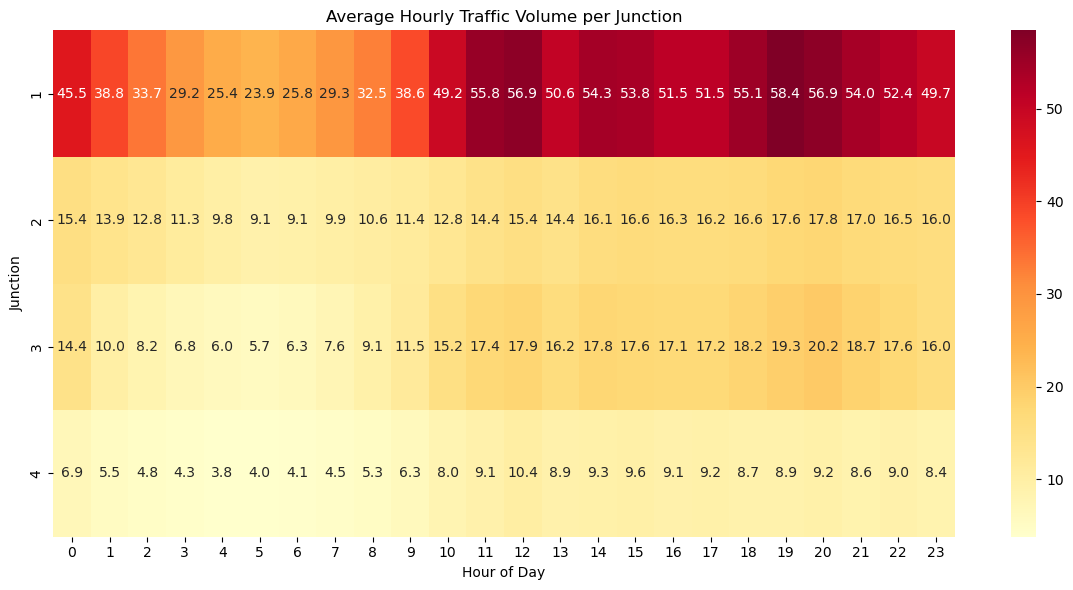

In [52]:
heatmap_data = hourly_congestion.pivot(index='Junction', columns='Hour', values='Avg_Vehicles')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlOrRd')
plt.title("Average Hourly Traffic Volume per Junction")
plt.xlabel("Hour of Day")
plt.ylabel("Junction")
plt.tight_layout()
plt.show()